# Function Definition

In [90]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
from keras import utils as np_utils
from keras.layers import Input

from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dropout, Activation, Flatten

In [48]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [49]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [50]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [51]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [52]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

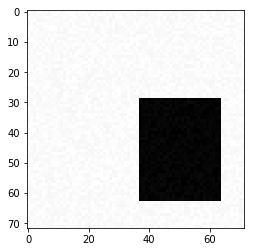

In [53]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

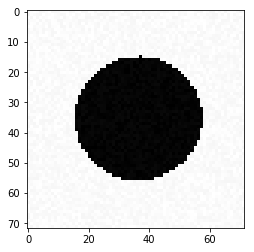

In [54]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

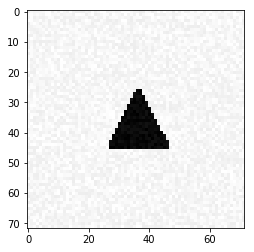

In [55]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [56]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [57]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [58]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [59]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [60]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Image Denoising

## Redefine triangle

In [61]:
#Redefine generate_a_triangle, return one image with noise and one without noise
def generate_a_triangle_noise(noise, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata_1 = generate_a_drawing(figsize, U, V, noise) #here's the image with noise
    imdata_2 = generate_a_drawing(figsize, U, V, 0) #here's the image without noise
    return [imdata_1,imdata_2, [U[0], V[0], U[1], V[1], U[2], V[2]]]

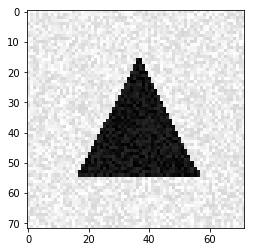

In [62]:
#Plot image with noise
im = generate_a_triangle_noise(50, False)
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

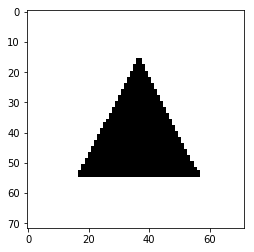

In [63]:
#Plot image without noise
plt.imshow(im[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Redefine disk

In [64]:
def generate_a_disk_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize,U,V,0)

## Redefine rectangle

In [72]:
def generate_a_rectangle_noise(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)

## Redefine data generate

In [73]:
def generate_dataset_classification_noise(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_noise(0)[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_noise(noise, free_location)[0]
            Y[i] = generate_a_rectangle_noise(noise, free_location)[1]
        elif category == 1: 
            X[i] = generate_a_disk_noise(noise, free_location)[0]
            Y[i] = generate_a_disk_noise(noise, free_location)[1]
        else:
            [X[i], Y[i], V] = generate_a_triangle_noise(noise, free_location)
           
        
    X = (X + noise) / (255 + 2 * noise)
    Y = (Y + 0)/(255+2*0)
    return [X, Y]

## Generate data

In [83]:
[X_train, Y_train] = generate_dataset_classification_noise(300, 20,False)
[X_test, Y_test] = generate_dataset_classification_noise(150,20,False)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [87]:
#Reformatting the data
X_train = X_train.reshape(len(X_train),72,72,1)
Y_train = Y_train.reshape(len(Y_train),72,72,1)
X_test = X_test.reshape(len(X_test),72,72,1)
Y_test = Y_test.reshape(len(Y_test),72,72,1)

## Train and test model

In [121]:
#hourglass network
input_img = Input(shape=(72,72,1))
conv1 = Conv2D(32,(3,3), activation = 'relu',padding='same')(input_img)
pool1 = MaxPooling2D(pool_size=(2,2), padding='same')(conv1)

up1 = UpSampling2D(size=(2,2))(pool1)
up_conv1 = Conv2D(32,(3,3),activation = 'relu',padding='same')(up1)
conv_up = Conv2D(1,(3,3),activation='sigmoid',padding='same')(up_conv1)

In [122]:
model = Model(input_img, conv_up)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 72, 72, 1)         289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.fit(X_train,Y_train, epochs=20, batch_size=128, shuffle=True, validation_split=0.3)

Train on 210 samples, validate on 90 samples
Epoch 1/20
210/210 [==============================] - 12s 57ms/step - loss: 0.6956 - acc: 0.4138 - val_loss: 0.6645 - val_acc: 0.7900
Epoch 2/20
210/210 [==============================] - 10s 47ms/step - loss: 0.6566 - acc: 0.7957 - val_loss: 0.6247 - val_acc: 0.7874
Epoch 3/20
210/210 [==============================] - 10s 49ms/step - loss: 0.6128 - acc: 0.7953 - val_loss: 0.5676 - val_acc: 0.7875
Epoch 4/20
210/210 [==============================] - 10s 48ms/step - loss: 0.5504 - acc: 0.7956 - val_loss: 0.4907 - val_acc: 0.7875
Epoch 5/20
210/210 [==============================] - 10s 48ms/step - loss: 0.4694 - acc: 0.7956 - val_loss: 0.4211 - val_acc: 0.7875
Epoch 6/20
210/210 [==============================] - 10s 48ms/step - loss: 0.4041 - acc: 0.7956 - val_loss: 0.3957 - val_acc: 0.7875
Epoch 7/20
210/210 [==============================] - 10s 48ms/step - loss: 0.3823 - acc: 0.7956 - val_loss: 0.3911 - val_acc: 0.7875
Epoch 8/20
210/21

In [124]:
#testing
model.evaluate(X_test,Y_test)

150/150 [==============================] - 2s 13ms/step


[0.3384993282953898, 0.8789519143104553]